In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time, TimeDelta
from astropy import units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.image as mpimg

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
def load_file(path):
    ncols = 4
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

The file below is obtained by running the `photo_icrf.script` GMAT script.

In [4]:
data = load_file('/home/daniel/jupyter_notebooks/dslwp/SunPosDSWLP.txt')
t = Time(mjd2unixtimestamp(data[:,0]), format='unix')

In [5]:
def ra(x):
    return ((np.arctan2(x[:,2], x[:,1]) + 2*np.pi) % (2*np.pi))/(2*np.pi)*24

def dec(x):
    return np.rad2deg(np.arctan(x[:,3]/np.sqrt(x[:,1]**2 + x[:,2]**2)))

In [6]:
best_time = np.argmin(np.abs(t - Time('2019-06-07 08:00:00')))
t[best_time].datetime

datetime.datetime(2019, 6, 7, 8, 1, 34, 886556)

In [7]:
camera_pointing = SkyCoord(ra = (ra(data)[best_time] + 12)*u.hour, dec = -dec(data)[best_time]*u.deg)

In [8]:
camera_pointing.ra.to_string(u.hour)

'16h58m57.1908s'

In [9]:
camera_pointing.dec.to_string(u.deg)

'-22d41m34.728s'

In [10]:
sun_dslwp = SkyCoord(ra = ra(data)[best_time]*u.hour, dec = dec(data)[best_time]*u.deg)
sun = astropy.coordinates.get_sun(t[best_time])
sun.separation(sun_dslwp).deg

0.10807942824021816

In [11]:
corr = fits.open('http://nova.astrometry.net/corr_file/3419256')

In [12]:
def separation(line):
    a = SkyCoord(ra = line['field_ra'] * u.deg, dec = line['field_dec'] * u.deg)
    b = SkyCoord(ra = line['index_ra'] * u.deg, dec = line['index_dec'] * u.deg)
    return a.separation(b)

In [13]:
np.sqrt(np.mean([separation(l).deg**2 for l in corr[1].data]))

0.02680675828456666

In [14]:
img = mpimg.imread('9b1c509a-1af6-4b7a-87f6-0efe085e2985.jpeg')

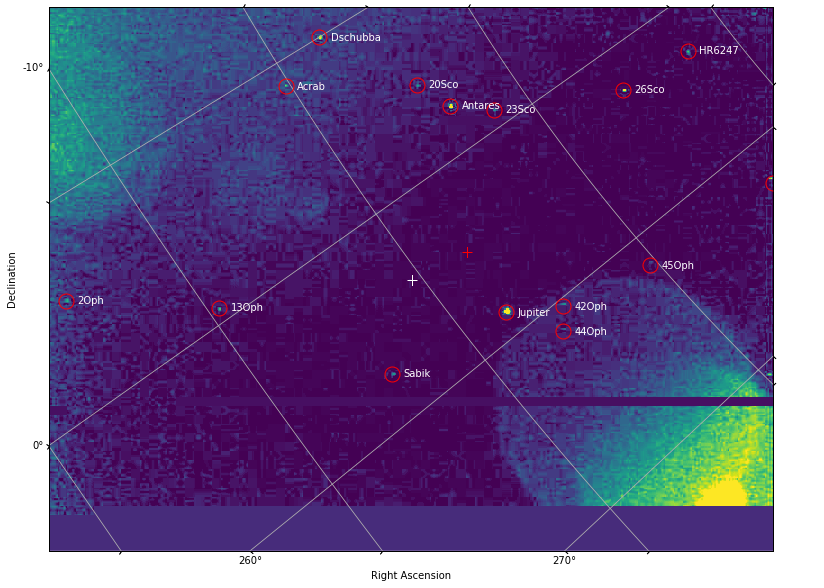

In [15]:
hdu = fits.open('http://nova.astrometry.net/new_fits_file/3423462')[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize = [14,10], facecolor = 'w')
ax = fig.add_subplot(111, projection = wcs)
#ax.imshow(hdu.data)
ax.imshow((np.sum(img, axis = 2)/150)**0.5, vmin = 0.4, vmax = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

for starname in ['Antares', '26Sco', 'HR6247', 'Dschubba', 'Jupiter', '23Sco', '20Sco', 'Acrab', '42Oph', '45Oph',
                 'Lesath', '44Oph', 'Sabik', '13Oph', '2Oph']:
    if starname in {'Jupiter'}:
        star = astropy.coordinates.get_body(starname, t[best_time])
    else:
        star = SkyCoord.from_name(starname)
    pix = wcs.all_world2pix(star.ra.deg, star.dec.deg, 0)
    ax.plot(pix[0], pix[1], 'o', markersize = 15, markerfacecolor = 'none', color = 'red')
    ax.text(pix[0]+10, pix[1]+3, starname, color = 'white')
    
ax.plot(hdu.data.shape[1]//2, hdu.data.shape[0]//2, '+', color = 'white', markersize = 10)
cam = wcs.all_world2pix(camera_pointing.ra.deg, camera_pointing.dec.deg, 0)
ax.plot(cam[0], cam[1], '+', color = 'red', markersize = 10)
    
ax.grid()

In [16]:
image_radec = wcs.all_pix2world(hdu.data.shape[1]/2, hdu.data.shape[0]/2, 0)
image_pointing = SkyCoord(ra = image_radec[0] * u.deg, dec = image_radec[1] * u.deg)
camera_pointing.separation(image_pointing)

<Angle 3.24764253 deg>